# Недообучение и переобучение

# Из методички

**Методические указания**

In [492]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Диагностика моделей классификации**

In [493]:
from sklearn.model_selection import train_test_split

Для первого примера воспользуемся синтетическими данными. Сгенерируем большой и достаточно сложный датасет для классификации. В нем будет 10 тысяч точек и 500 атрибутов. Из них всего 50 признаков будут информативными. Сразу после генерации разделим получившийся датасет на обучающую и тестовую выборки.

In [494]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=500,
                           n_informative=50, n_repeated=0,
                           class_sep=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=3)

In [495]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8413
Test score: 0.8056


То, насколько отличается обучающая и тестовая эффективность модели - основной индикатор пере- или недообучения. Мы явно видим, что тестовая эффективность полученной модели неидеальна. Определить, что является причиной снижения качества модели - ее излишняя или недостаточная вариативность - основная цель диагностики модели машинного обучения

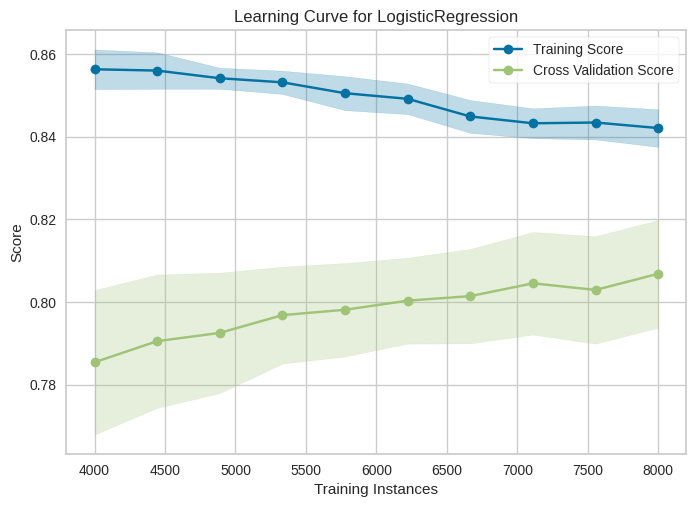

In [496]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y).show()

Эта функция обучает модели логистической регрессии на долях обучающей выборки от 10% до 100%, вычисляет точность на обучающей и тестовой выборках и строит кривую обучения.

Кривая показывает, что при малом объеме данных модель переобучается: высокая точность на обучении и низкая — на тесте. С увеличением данных показатели сближаются, но остаётся разрыв.

Большой разрыв между обучающей и тестовой эффективностью указывает на переобучение, а низкая обучающая эффективность — на недообучение. В нашем случае вероятно лёгкое переобучение, что подтверждается разреженностью сгенерированного датасета. Точнее оценить можно при сравнении с другими моделями, например, с регуляризацией.

Мы используем классификатор на основе гребневой регрессии. Напомним, что логистическая регрессия — это частный случай гребневой модели с нулевой регуляризацией. Увеличивая параметр регуляризации, мы упрощаем модель. Поскольку исходная модель склонна к переобучению, попробуем модель с более сильной регуляризацией.

In [497]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.7724
Test score: 0.7712


Эффективность снизилась, но обучающая и тестовая метрики почти совпадают, что подтверждает переобучение в первой модели и эффективность регуляризации.

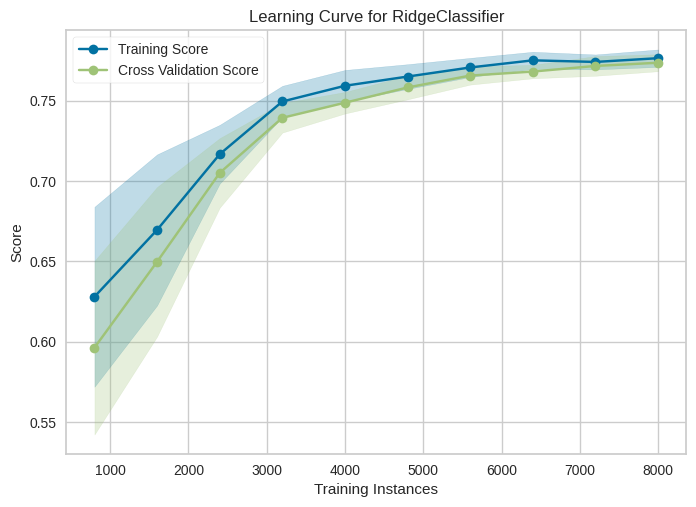

In [498]:
visualizer = LearningCurve(
    RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

При анализе важно учитывать масштаб оси Y: хотя кажется, что значения выше, на самом деле они ниже. Такой график типичен для недообучения — низкая эффективность и почти нет разницы между обучением и тестом.

Для того, чтобы проанализировать данную задачу еще более глубоко построим график зависимости эффективности модели от значения параметра регуляризации. Для этого воспользуется логравномерным распределением.

Код строит 50 моделей с разным уровнем регуляризации от 10² до 10⁶. Диапазон подбирается эмпирически и зависит от задачи, поэтому сначала стоит пробовать широкий интервал (например, от 10⁻⁶ до 10⁶), а затем уточнять его для наглядного графика.

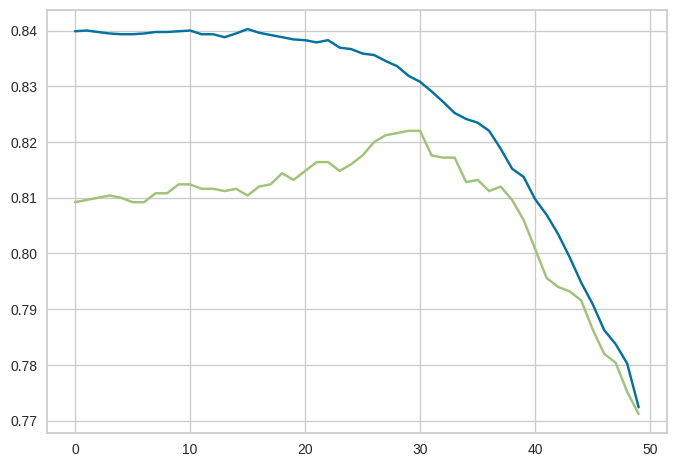

In [499]:
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(2, 6, 50):
  ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
  trains.append(ridge.score(X_train, y_train))
  tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)

Здесь мы видим, что при определенных значениях параметра регуляризации тестовая эффективность модели (а нас в конечном итоге интересует именно она) лучше, чем во всех остальных. Подбором или алгоритмически можно найти такое оптимальное значение параметра регуляризации. Оно дает нам модель, которая имеет оптимальный уровень сложности для данного конкретного датасета.

In [500]:
from sklearn.linear_model import RidgeClassifier
lr = RidgeClassifier(alpha=26500).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8311
Test score: 0.8228


Эта модель получилась немного лучше, чем самая первая, модель логистической регрессии.

**Диагностика моделей регрессии**

In [501]:
url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

X = data
y = target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Это набор данных для решения задачи регрессии - предсказания цен объектов недвижимости по их характеристикам.

In [502]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print("Linear Regression - Training set score:", round(model.score(X_train, y_train), 2))
print("Linear Regression - Test set score:", round(model.score(X_test, y_test), 2))

Linear Regression - Training set score: 0.77
Linear Regression - Test set score: 0.64


Большой разрыв между обучающей и тестовой эффективностью также сразу должен навести на мысль о переобучении данной модели.

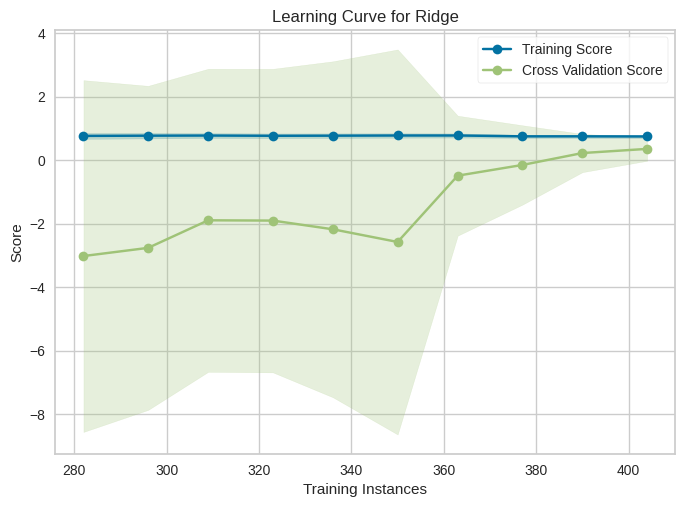

In [503]:
from yellowbrick.model_selection import LearningCurve
from sklearn.linear_model import Ridge

visualizer = LearningCurve(
    Ridge(alpha=0.0001), scoring='r2', train_sizes=np.linspace(0.7, 1.0, 10)
).fit(X, y) .show()

Хотя визуально разрыв кажется небольшим, в правой части графика он всё ещё значительный — ось Y смещена вниз из-за крайне низкой тестовой эффективности слева. Это указывает на переобучение модели.

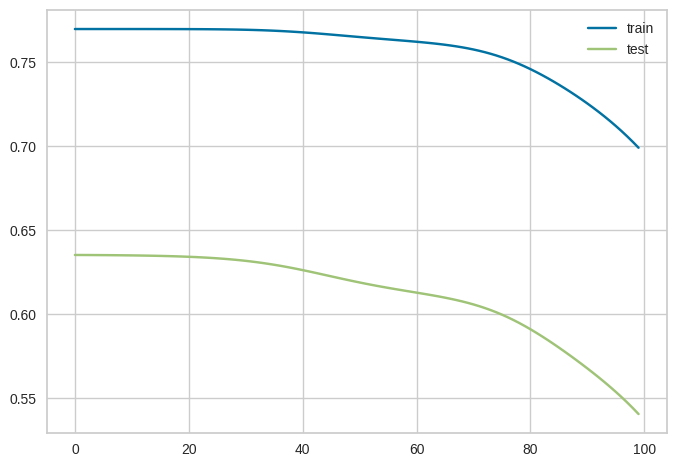

In [504]:
from sklearn.linear_model import Ridge

trains = []
tests = []
alphas = np.logspace(-2, 3, 100)

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)

    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

График чётко показывает поведение регуляризации: слева — переобучение (модели сложные, хороши на обучении, но плохи на тесте), справа — недообучение (модели слишком простые, низкая точность везде). Оптимальная сложность — посередине, и здесь она выражена особенно наглядно.

In [505]:
lr = Ridge(alpha=0.18).fit(X_train, y_train)

print(f"Linear Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Linear Regression-Test set score: {lr.score(X_test, y_test):.2f}")

Linear Regression-Training set score: 0.77
Linear Regression-Test set score: 0.63


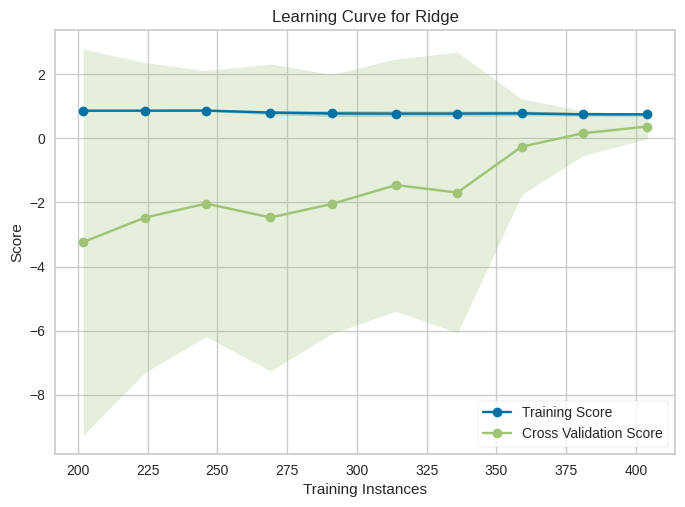

In [506]:
visualizer = LearningCurve(
    Ridge(alpha=0.18), scoring='r2', train_sizes=np.linspace(0.5, 1.0, 10)
).fit(X, y) .show()

Можно попробовать другой вид регуляризации - лассо. В библиотеке sklearn эта модель работает только как регрессор, то есть она не подходит для задач классификации.

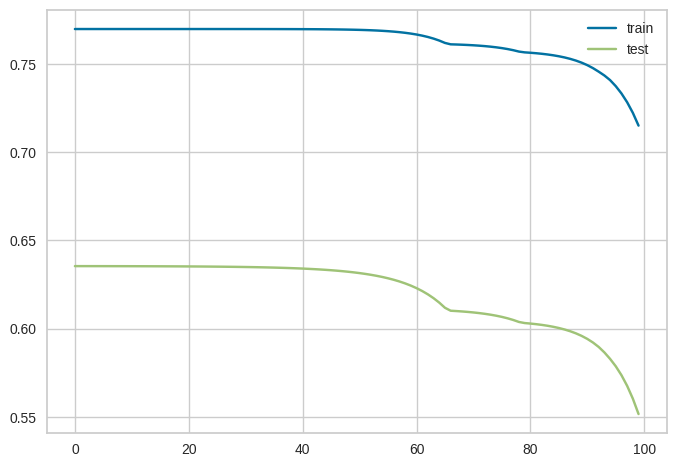

In [507]:
from sklearn.linear_model import Lasso
trains = []
tests = []
for i in np.logspace(-4, 0, 100):
  ridge = Lasso(alpha=i).fit(X_train, y_train)
  trains.append(ridge.score(X_train, y_train))
  tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

**Диагностика на реальных данных**

Будем использовать известный датасет для классификации "Диабет".

In [508]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/koroteevmv/ML_course/2023/ML4.3%20diagnostics/diabetes.csv',nrows=200)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [509]:
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [510]:
from sklearn.metrics import accuracy_score

In [511]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 1.0000
Test score = 0.5500


Даже без построения кривых обучения здесь очевидно переобучение модели.

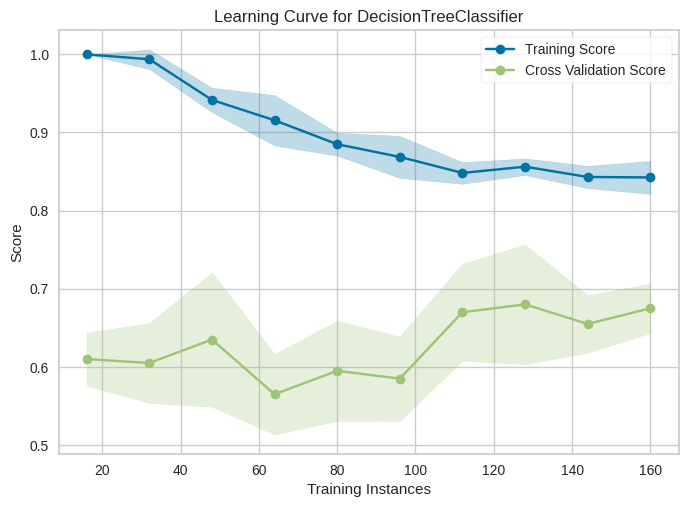

In [512]:
visualizer = LearningCurve(
    DecisionTreeClassifier(max_depth=4), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X, y) .show()

Для иллюстрации этого повторим обучение нерегуляризованного дерева решений на всем датасете.

In [513]:
df = pd.read_csv('https://raw.githubusercontent.com/koroteevmv/ML_course/2023/ML4.3%20diagnostics/diabetes.csv')
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
from sklearn.metrics import f1_score
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 1.0000
Test score = 0.7273


Получившаяся модель значительно лучше, чем даже регуляризованное дерево. В общем случае, добавление данных работает лучше, чем регуляризация.

**Диагностика недообучения**

В sklearn есть встроенный механизм загрузки датасетов из онлайн репозитория OpenML. Возьмем оттуда датасет, посвященный проблеме управления истребителем F16.

In [514]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='delta_ailerons', parser="auto")
data.data.shape

(7129, 5)

In [515]:
X = pd.get_dummies(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Создадим и оценим простую модель логистической регрессии.

In [516]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.6092
Test score = 0.5989


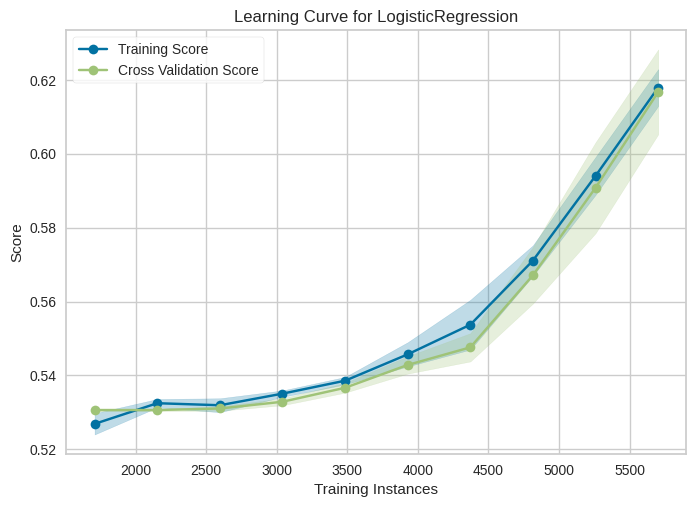

In [517]:
visualizer = LearningCurve(
    LogisticRegression(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
).fit(X, y) .show()

Здесь очевидны признаки недообучения: низкий уровень обучающей эффективности, малый разрыв между обучающей и тестовой эффективностью. При недообучении регуляризация не поможет, даже навредит, так как еще усилит его. Поэтому единственный путь в этом случае - использовать более сложные, вариативные модели

Можно, например, попробовать многослойный перцептрон.

In [518]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9388
Test score = 0.9404


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Эффективность модели сильно выросла.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

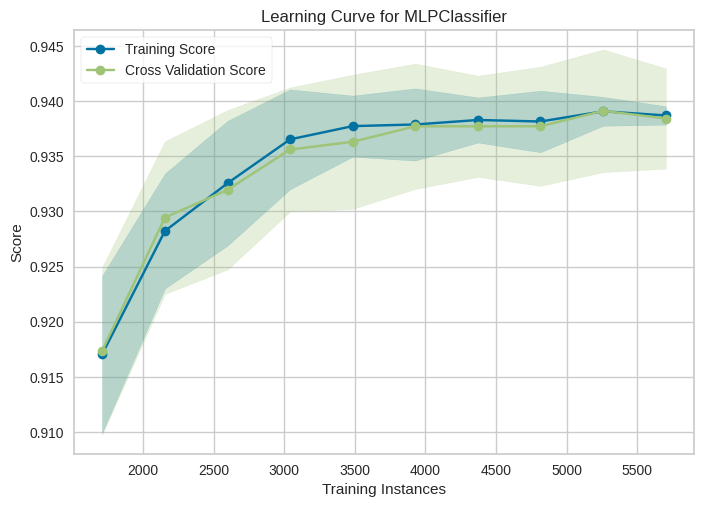

In [519]:
visualizer = LearningCurve(
    MLPClassifier(), scoring='accuracy', train_sizes=np.linspace(0.3, 1.0, 10)
).fit(X, y) .show()

Кроме использования более вариативных моделей самих по себе можно ввести в модель полиномиальные признаки.

In [520]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
model = RidgeClassifier(alpha=0.001).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
y_train_pred = model.predict(PolynomialFeatures(2).fit_transform(X_train))
y_pred = model.predict(PolynomialFeatures(2).fit_transform(X_test))
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 0.9392
Test score = 0.9362


Полиномиальные модели являются естественным усложнением линейных и поэтому в случае недообучения исходной модели почти всегда обеспечивают увеличение эффективности модели.

Для этой полиномиальной модели уже можно пробовать использовать регуляризацию и строить соответствующие кривые.

In [521]:
from sklearn.linear_model import RidgeClassifier
trains = []
tests = []
for i in np.logspace(-7, 0, 100):
  ridge = RidgeClassifier(alpha=i).fit(PolynomialFeatures(2).fit_transform(X_train), y_train)
  trains.append(ridge.score(PolynomialFeatures(2).fit_transform(X_train), y_train))
  tests.append(ridge.score(PolynomialFeatures(2).fit_transform(X_test), y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()

KeyboardInterrupt: 

На этом графике кривая регуляризации менее очевидна. Видна область недообучения справа, но переобучение не выражено, так как тестовая эффективность почти не снижается. График менее гладкий из-за случайных отклонений, артефактов в данных и стохастичности процесса обучения.

# Задания для самостоятельного выполнения

*1. Повторите диагностику модели классификации синтетических данных с использованием других метрик эффективности - precision, recall, F1. Как изменились результаты?*

In [563]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [564]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [565]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [566]:
y_pred = model.predict(X_test)

In [567]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [568]:
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.92
Recall: 0.83
F1 Score: 0.87


Precision = 0.92 — точность модели достаточно высокая. Это свидетельствует о том, что модель делает мало ложных положительных ошибок.

Recall = 0.83 — полнота модели тоже достаточно хорошая. Это означает, что модель правильно распознает 83% всех реальных положительных примеров.

F1 Score = 0.87 — F1 показывает хороший баланс между точностью и полнотой. Это значение говорит о том, что модель достаточно хорошо справляется с задачей классификации.

*2. Повторите диагностику модели регрессии с использованием других видов моделей:*

*метода опорных векторов (исследуйте влияние параметра С на недо-и переобучение)*

*метода ближайших соседей (исследуйте влияние количества соседей)*

*метода решающих деревьев (гиперпараметры по вашему выбору)*

**метод опорных векторов**

In [569]:
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

In [570]:
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

In [571]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [572]:
for C_value in [0.1, 1, 10, 100]:
    model = SVR(C=C_value)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"C = {C_value}, MSE = {mse}")

C = 0.1, MSE = 16593.806458458857
C = 1, MSE = 12758.14612986086
C = 10, MSE = 2190.7532771857354
C = 100, MSE = 521.6938100644521


С = 0.1 - модель сильно ограничивает ошибку на тренировочных данных, что приводит к недообучению. Модель слишком сильно упрощена и не может хорошо предсказывать на тестовых данных (высокое значение MSE).

С = 1 - MSE все еще довольно высокий. Также указывает на недообучение.

С = 10 - ошибка на тестовых данных существенно уменьшилась. Значение С дает достаточно гибкую модель.

С = 100 - модель начинает переобучаться, так как модель пытается подстроиться под каждый элемент в тренировочных данных, что снижает ее способность обобщать.

Оптимальный выбор - С = 10.

**метод ближайших соседей**

In [573]:
from sklearn.neighbors import KNeighborsRegressor

In [574]:
for K_value in [1, 5, 10, 20]:
    model = KNeighborsRegressor(n_neighbors=K_value)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"K = {K_value}, MSE = {mse}")

K = 1, MSE = 7296.534500569418
K = 5, MSE = 3728.3442939729885
K = 10, MSE = 3606.40533164709
K = 20, MSE = 4244.132949700267


К = 1 - высокое значение MSE говорит о переобучении, каждый новый прогноз зависит от одного ближайшего соседа (высокая вариативность модели).

К = 5 - модель меньше склонна к переобучению.

К = 10 - MSE почти на уровне К = 5, но с легким улучшением.

К = 20 - ошибка увеличивается. Модель теряет способность правильно подстраиваться под данные, что приводит к недообучению.

Оптимальный выбор - K = 5, 10.

**метод решающих деревьев**

In [575]:
from sklearn.tree import DecisionTreeRegressor

In [576]:
for depth in [2, 5, 10, 20]:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"max_depth = {depth}, MSE = {mse}")

max_depth = 2, MSE = 10677.931337339664
max_depth = 5, MSE = 6512.19821678051
max_depth = 10, MSE = 6293.165992299749
max_depth = 20, MSE = 6184.599589672387


max_depth = 2 - решающее дерево имеет ограниченную глубину, учитывает только ограниченное кол-во признаков для принятия решений. Приводит к сильному недообучению.

max_depth = 5 - MSE уменьшается, улучшение качества модели. Недостаточно сложное, чтобы переобучиться.

max_depth = 10 - MSE уменьшается, улучшение модели по сравнению max_depth = 5.

max_depth = 20 - MSE увеличивается, может свидетельствовать о переобучении, дерево стало слишком глубоким.


Наилучший выбор - max_depth = 10.

*3. Дополните анализ датасета Бостон исследованием модели лассо - постройте кривые обучения для переобученной, недообученной и качественной модели.*

In [577]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

In [578]:
california = fetch_california_housing()
X, y = california.data, california.target

In [579]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [580]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [581]:
alphas = {
    "underfitting": 1000,
    "overfitting": 0.0001,
    "optimal": 0.1
}

In [582]:
def plot_learning_curve(model, X_train, y_train, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, train_sizes=np.linspace(0.3, 1.0, 10), scoring='neg_mean_squared_error'
    )

    train_errors = -train_scores.mean(axis=1)
    test_errors = -test_scores.mean(axis=1)

    plt.plot(train_sizes, train_errors, label="Обучающая ошибка", color='blue', linestyle='-', marker='o')
    plt.plot(train_sizes, test_errors, label="Тестовая ошибка", color='red', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel("Размер обучающей выборки")
    plt.ylabel("Среднеквадратичная ошибка (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

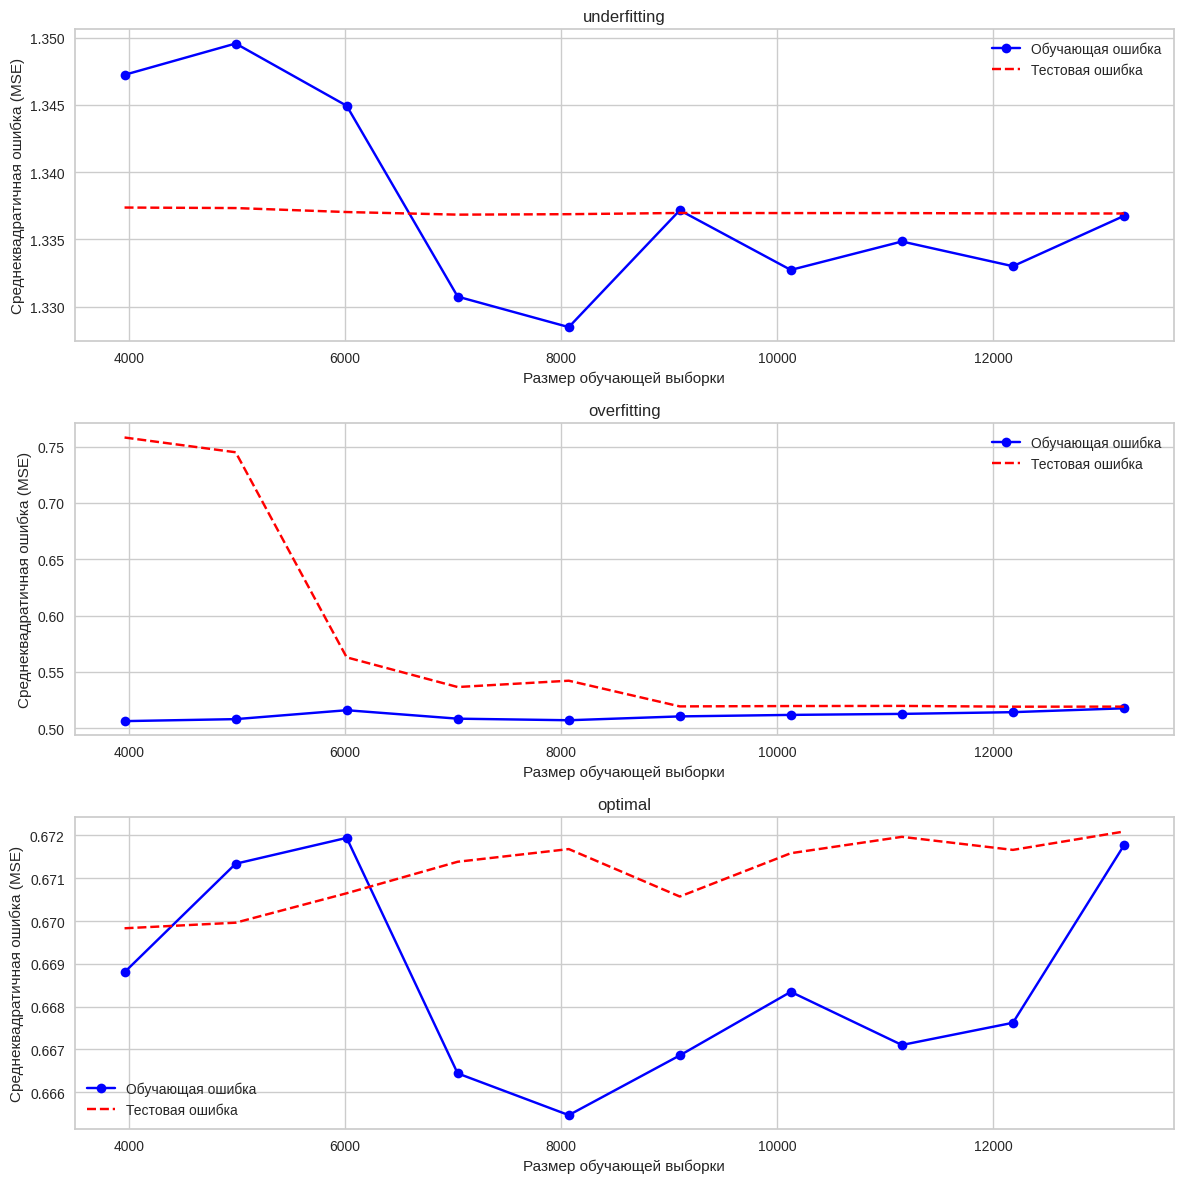

In [583]:
plt.figure(figsize=(12, 12))

for i, (label, alpha) in enumerate(alphas.items(), 1):
    plt.subplot(3, 1, i)
    model = Lasso(alpha=alpha)
    plot_learning_curve(model, X_train, y_train, title=label)

plt.show()

Underfitting - ошибки высокие, модель не учится

Overfitting - ошибка на тесте сильно выше

Optimal - ошибки низкие и близкие, модель готова к использованию

*4. В одном из двух первых примеров используйте модель ElasticNet и исследуйте влияние сразу двух параметров регуляризации на эффективность модели.*

In [584]:
from sklearn.linear_model import ElasticNet

In [585]:
alphas = [0.1, 1, 10]
l1_ratios = [0.2, 0.5, 0.8]
for alpha in alphas:
    for l1_ratio in l1_ratios:
        model_en = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        model_en.fit(X_train, y_train)
        y_pred = model_en.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"ElasticNet с alpha={alpha}, l1_ratio={l1_ratio} - MSE: {mse:.4f}")

ElasticNet с alpha=0.1, l1_ratio=0.2 - MSE: 0.6013
ElasticNet с alpha=0.1, l1_ratio=0.5 - MSE: 0.6359
ElasticNet с alpha=0.1, l1_ratio=0.8 - MSE: 0.6719
ElasticNet с alpha=1, l1_ratio=0.2 - MSE: 0.9088
ElasticNet с alpha=1, l1_ratio=0.5 - MSE: 1.0442
ElasticNet с alpha=1, l1_ratio=0.8 - MSE: 1.3107
ElasticNet с alpha=10, l1_ratio=0.2 - MSE: 1.3107
ElasticNet с alpha=10, l1_ratio=0.5 - MSE: 1.3107
ElasticNet с alpha=10, l1_ratio=0.8 - MSE: 1.3107


При alpha = 0.1 и для разных значений l1_ratio видно, что MSE постепенно увеличивается. Это указывает на то, что небольшая L1 делает модель более устойчивой.

При alpha = 1 и разном l1_ratio MSE увеличивается значительно. Это указывает на то, что увеличение alpha приводит к сильной регуляризации и модель теряет способность подстраиваться под данные. Чем выше alpha, тем сильнее влияние регуляризации и тем выше ошибка, что свидетельствует о недообучении.

При alpha = 10 MSE стабилизировалась. Это подтверждает, что очень высокая регуляризация ограничивает способность модели обучаться.



*6. Повторите анализ на других реальных датасетах из репозитория OpenML:*

*phoneme*

*banknote-authentication*

*delta_ailerons*

*mammography*

*mozilla4*

*volcanoes-b3*


**phoneme**

Датасет содержит данные для классификации фонем в английском языке. Каждый пример представляет собой характеристику звука. Модель должна предсказать фонему на основе этих характеристик. Кол-во признаков - 5, размер выборки - 5858, целевая переменная - классы фонем.

In [723]:
from openml.datasets import get_dataset

In [724]:
dataset = get_dataset(1489)
dataset

OpenML Dataset
Name.........: phoneme
Version......: 1
Format.......: ARFF
Upload Date..: 2015-05-25 19:34:17
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/1592281/phoneme.arff
OpenML URL...: https://www.openml.org/d/1489
# of features: None

In [725]:
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [726]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [727]:
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [728]:
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [729]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [730]:
train_accuracy, test_accuracy


(1.0, 0.8436632747456059)

На обучающих данных точность 100%, на тестовых - 84.37%.

Высокая точность на обучающих данных и заметное снижение на тестовых данных. Модель возможно переобучена на тренировочных данных.

**banknote-authentication**

Датасет содержит признаки изображений банкнот (цвет, контраст и т.д.). Целью является классификация банкнот как подлинных или фальшивых. Кол-во признаков - 4, размер выборки - 1372, целевая переменная - классы банкнот.

In [731]:
dataset = get_dataset(1462)
dataset

OpenML Dataset
Name.........: banknote-authentication
Version......: 1
Format.......: ARFF
Upload Date..: 2015-05-21 22:40:57
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/1586223/banknote-authentication.arff
OpenML URL...: https://www.openml.org/d/1462
# of features: None

In [732]:
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [733]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [734]:
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [735]:
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [736]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [737]:
train_accuracy, test_accuracy

(1.0, 0.9745454545454545)

На обучающих данных точность 100%, на тестовых - 97.45%.

Модель показывает отличные результаты.

**delta_ailerons**

Датасет состоит из данных о крыльях самолета с целью предсказать отклонения закрылок. Кол-во признаков - 5, размер выборки - 1000, целевая переменная - отклонение закрылок.

In [738]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [739]:
dataset = get_dataset(43995)
dataset

OpenML Dataset
Name.........: Ailerons
Version......: 4
Format.......: arff
Upload Date..: 2022-06-16 20:50:39
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/22103083/Ailerons.arff
OpenML URL...: https://www.openml.org/d/43995
# of features: None

In [740]:
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [741]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [742]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [743]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [744]:
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [745]:
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Train R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")

Train MSE: 0.0000
Test MSE: 0.0000
Train R²: 0.8174
Test R²: 0.8256


Модель имеет очень хорошие результаты с низким MSE и высоким R^2.

**mammography**

Датасет используется для диагностики рака молочной железы на основе маммографических изображений. Кол-во признаков - 6, размер выборки - 1400, целевая переменная - класс образования (доброкачественное/злокачественное).

In [746]:
dataset = get_dataset(310)
dataset

OpenML Dataset
Name.........: mammography
Version......: 1
Format.......: ARFF
Upload Date..: 2014-08-25 11:38:52
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/52214/mammography.arff
OpenML URL...: https://www.openml.org/d/310
# of features: None

In [747]:
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [748]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [749]:
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [750]:
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [751]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [752]:
train_accuracy, test_accuracy

(0.9994410909903868, 0.986142154671435)

Точность на обучающих данных - 99.94%, на тестовых - 98.61%.

Модель хорошо обучается.

**mozilla4**

Датасет содержит данные для классификации типов аудиофайлов. Кол-во признаков - 22, размер выборки - 5000, целевая переменнная - классы аудиофайлов.

In [753]:
dataset = get_dataset(1046)
dataset

OpenML Dataset
Name.........: mozilla4
Version......: 1
Format.......: ARFF
Upload Date..: 2014-10-06 23:57:07
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/53929/mozilla4.arff
OpenML URL...: https://www.openml.org/d/1046
# of features: None

In [754]:
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [755]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [756]:
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [757]:
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [758]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [759]:
train_accuracy, test_accuracy

(1.0, 0.9376005146349309)

Модель продемонстрировала хорошие результаты.

**volcanoes-b3**

Каждая запись содержит характеристики вулканов. Цель - классифицировать вулканы по степени активности.

In [760]:
dataset = get_dataset(1533)
dataset

OpenML Dataset
Name.........: volcanoes-b3
Version......: 1
Format.......: ARFF
Upload Date..: 2015-06-01 19:30:48
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/1593729/volcanoes-b3.arff
OpenML URL...: https://www.openml.org/d/1533
# of features: None

In [761]:
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

In [762]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [763]:
dtc = DecisionTreeClassifier(random_state=1)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [764]:
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [765]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

In [766]:
train_accuracy, test_accuracy

(1.0, 0.9432146294513956)

Модель дает хорошие результаты.